In [1]:
import numpy as np
from numba import cuda
import numba
import math
import matplotlib as mpl
import matplotlib.pylab as plt

from matplotlib import animation, rc
from IPython.display import HTML
cmap = mpl.cm.get_cmap(name='viridis')
import time

%load_ext autoreload
%autoreload 2
%matplotlib notebook

cuda.detect()
cntx= cuda.current_context()
cntx.reset()

CudaSupportError: Error at driver init: Call to cuInit results in CUDA_ERROR_NO_DEVICE (100)

# simulation parameters

In [2]:
cntx.reset()


In [3]:
import time
t0= time.time()
print("Start")

l2arr_varyingtau=[]
l2arr=[]

w0 = 4.0/9.0  # zero weight
ws = 1.0/9.0  # adjacent weight
wd = 1.0/36.0 # diagonal weight
cs = 1/np.sqrt(3) #speed of sound


origin_x=360
origin_y=60
origin_speed_sound=10
origin_speed_inlet=0.5
origin_cylinder_D=10
Re=57

scale=1                # set simulation size
conversion_factor=4
NX=origin_x*conversion_factor*scale             # channel length
NY=origin_y*conversion_factor*scale             # channel width



u_in=cs*origin_speed_inlet/origin_speed_sound #inlet velocity
cylinder_D=origin_cylinder_D*conversion_factor
t_dimensionless=50
NSTEPS=int(t_dimensionless*cylinder_D/u_in*(scale**2))  # number of simulation time steps#NSTEPS=int(1e4*(scale**2)) 

eta=cylinder_D*u_in/Re #dynamic viscosity eta
omegaplus=1/((eta/cs**2)+1/2)

lamda=3/16
omegaminus=1/(lamda/(1/(omegaplus)-0.5)+0.5)


# Lattice parameters
NPOP=9
w = np.array([4/9,1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]) 
c = np.array([[0, 1, 0, -1,  0, 1, -1, -1,  1],  # velocities, x components
              [0, 0, 1,  0, -1, 1,  1, -1, -1]]) # velocities, y components

#Node locations
x = np.arange(NX)+0.5
y = np.arange(NY)+0.5
# [X, Y] = np.meshgrid(x,y)

#Wall locations
ybottom=1
ytop=NY-1


#initialize populations

feq=np.zeros((NX,NY,NPOP))
rho=np.ones((NX,NY))      
f=feq.copy()   
fprop=feq.copy()  


Start


# Creating Wallnodesarray (wall nodes=1, otherwise 0)

In [4]:

wallnodesarr=np.zeros((NX,NY))


centerx=int(NX*25/360)
centery=int(NY/2)
radius=int(cylinder_D/2)
for i in range (centerx-radius,centerx+radius):
    for j in range(centery-radius,centery+radius):
        if np.sqrt((i-centerx)**2+(j-centery)**2)<=radius:
            wallnodesarr[i][j]=1


Qarray_original=np.array([0,1,2,3,4,5,6,7,8])
Qarray_prop=np.array([0,3,4,1,2,7,8,5,6])
nodes_near_walls=[]
#propagating calculation
for i in range(0,NX):
    for j in range(1,NY-1):
        isneighbor=False
        original_dir=[]
#         propagate_dir=[]
        #whether left is wallnode
        if(i==0):
            continue
        else:
            if(wallnodesarr[i-1][j])==1:
                isneighbor=True
                original_dir.append(1)
        #whether left-up is wallnode
        if(i==0):
#             continue
            isneighbor=True
            original_dir.append(8)
        else:
            if(wallnodesarr[i-1][j+1])==1:
                isneighbor=True
                original_dir.append(8)
        #whether up is wallnode
        if(wallnodesarr[i][j+1])==1:
            isneighbor=True
            original_dir.append(4)
        #whether up-right is wallnode
        if(i==NX-1):
            if(wallnodesarr[0][j+1])==1:
                isneighbor=True
                original_dir.append(7)
       
        else:
            if(wallnodesarr[i+1][j+1])==1:
                isneighbor=True
                original_dir.append(7)  
        #whether right is wallnode
        if(i==NX-1):
#             if(wallnodesarr[0][j])==1:
#                 isneighbor=True
#                 original_dir.append(3print
            continue
        else:
            if(wallnodesarr[i+1][j])==1:
                isneighbor=True
                original_dir.append(3) 
         #whether right-down is wallnode
        if(i==NX-1):
            if(wallnodesarr[0][j-1])==1:
                isneighbor=True
                original_dir.append(6)

        else:
            if(wallnodesarr[i+1][j-1])==1:
                isneighbor=True
                original_dir.append(6)
        #whether down is wallnode
        if(wallnodesarr[i][j-1])==1:
            isneighbor=True
            original_dir.append(2)
        #whether down left is wallnode
        if(i==0):
#             continue
            isneighbor=True
            original_dir.append(2)
        else:
            if(wallnodesarr[i-1][j-1])==1:
                isneighbor=True
                original_dir.append(5)
        if(isneighbor==True):
            nodeinfo=[]
            nodeinfo.append([i,j])
            nodeinfo.append(original_dir)
            nodes_near_walls.append(nodeinfo)        
       

# GPU parameters

In [5]:
cntx.reset()


In [6]:
@cuda.jit(device=True,inline=True)
def FieldNIndex(x,y,d):
    return(NX*(NY*(d-1)+y)+x)
@cuda.jit(device=True,inline=True)
def ScalarIndex(x,y):
    return(NX*y+x)

In [7]:
def FieldNIndex_CPU(x,y,d):
    return(NX*(NY*(d-1)+y)+x)

In [8]:
nodes_near_neighbor_arr=np.full(NX*NY*8,0.0,float)
for i in range(len(nodes_near_walls)):
    for j in range(len(nodes_near_walls[i][1])):
        nodes_near_neighbor_arr[FieldNIndex_CPU(nodes_near_walls[i][0][0],nodes_near_walls[i][0][1],nodes_near_walls[i][1][j])]=1

In [9]:
#CUDA Device Functions:
@cuda.jit()
def PropagateFluid(f0,f1,f2,u,v,nodes_near_walls_g,vortex,f0eq,feq):
    x,y = cuda.grid(2)
    xp1 = (x+1)%NX
    yp1 = (y+1)%NY
    xm1 = (NX+x-1)%NX
    ym1 = (NY+y-1)%NY

    ft0 = f0[ScalarIndex(x,y)]
    ft1 = f1[FieldNIndex(xm1,y  ,1)]
    ft2 = f1[FieldNIndex(x  ,ym1,2)]
    ft3 = f1[FieldNIndex(xp1,y  ,3)]
    ft4 = f1[FieldNIndex(x  ,yp1,4)]
    ft5 = f1[FieldNIndex(xm1,ym1,5)]
    ft6 = f1[FieldNIndex(xp1,ym1,6)]
    ft7 = f1[FieldNIndex(xp1,yp1,7)]
    ft8 = f1[FieldNIndex(xm1,yp1,8)]
    # connection vectors q
    #6 2 5
    #3 0 1
    #7 4 8
    
    drho = ft0+ft1+ft2+ft3+ft4+ft5+ft6+ft7+ft8

    
#     ###### BOUNDARIES #############
#     Applying bounce-back rules to all nodes near walls
    if nodes_near_walls_g[FieldNIndex(x,y,1)]==1:
        ft1 = f1[FieldNIndex(x ,y  ,3)]
    if nodes_near_walls_g[FieldNIndex(x,y,2)]==1:
        ft2 = f1[FieldNIndex(x  ,y,4)]
    if nodes_near_walls_g[FieldNIndex(x,y,3)]==1:
        ft3 = f1[FieldNIndex(x  ,y,1)]
    if nodes_near_walls_g[FieldNIndex(x,y,4)]==1:
        ft4 = f1[FieldNIndex(x  ,y,2)]    
    if nodes_near_walls_g[FieldNIndex(x,y,5)]==1:
        ft5 = f1[FieldNIndex(x  ,y,7)]    
    if nodes_near_walls_g[FieldNIndex(x,y,6)]==1:
        ft6 = f1[FieldNIndex(x  ,y,8)]
    if nodes_near_walls_g[FieldNIndex(x,y,7)]==1:
        ft7 = f1[FieldNIndex(x  ,y,5)]
    if nodes_near_walls_g[FieldNIndex(x,y,8)]==1:
        ft8 = f1[FieldNIndex(x  ,y,6)]
        
        
    if(x==0):
        ft1=f1[FieldNIndex(x ,y  ,3)]-2*ws*1*3*(-1)*u_in
        ft5=f1[FieldNIndex(x ,y  ,7)]-2*wd*1*3*(-1)*u_in
        ft8=f1[FieldNIndex(x ,y  ,6)]-2*wd*1*3*(-1)*u_in



    
    
    cuda.syncthreads()
    f0[ScalarIndex(x,y)]   = ft0
    f2[FieldNIndex(x,y,1)] = ft1
    f2[FieldNIndex(x,y,2)] = ft2
    f2[FieldNIndex(x,y,3)] = ft3
    f2[FieldNIndex(x,y,4)] = ft4
    f2[FieldNIndex(x,y,5)] = ft5
    f2[FieldNIndex(x,y,6)] = ft6
    f2[FieldNIndex(x,y,7)] = ft7
    f2[FieldNIndex(x,y,8)] = ft8
    
    u[ScalarIndex(x,y)] = (ft1+ft5+ft8)-(ft3+ft6+ft7)
    v[ScalarIndex(x,y)] = (ft2+ft5+ft6)-(ft4+ft7+ft8)
    

    #Vortex
    if x<=1 or x>=NX-2:
        vortex[ScalarIndex(x,y)]=0
    else:
        # right is wallnode (backward finite difference : 1/2, -2, 3/2
        if nodes_near_walls_g[FieldNIndex(x,y,1)]==1:
            vortex[ScalarIndex(x,y)]=(u[ScalarIndex(x,y%(NY-1)+1)]-u[ScalarIndex(x,y-1)])
            -(v[ScalarIndex(x,y)]*3/2+v[ScalarIndex(x-1,y)]*-2+v[ScalarIndex(x-2,y)]*1/2)
        
        #if up is wall node(backward finite difference)
        if nodes_near_walls_g[FieldNIndex(x,y,2)]==1:
            vortex[ScalarIndex(x,y)]=(u[ScalarIndex(x,y)]*3/2+u[ScalarIndex(x,y-1)]*-2+u[ScalarIndex(x,y-2)]*1/2)
            -(v[ScalarIndex(x+1,y)]-v[ScalarIndex(x-1,y)])/2
            
        #if left is wall node(forward finite difference): -3/2. 2, -1/2
        if nodes_near_walls_g[FieldNIndex(x,y,2)]==1:
            vortex[ScalarIndex(x,y)]=(u[ScalarIndex(x,y%(NY-1)+1)]-u[ScalarIndex(x,y-1)])
            -(v[ScalarIndex(x,y)]*-3/2+v[ScalarIndex(x+1,y)]*2+v[ScalarIndex(x+2,y)]*-1/2)
            
        #if down is wall node(forward finite difference): -3/2. 2, -1/2
        if nodes_near_walls_g[FieldNIndex(x,y,2)]==1:
            vortex[ScalarIndex(x,y)]=(u[ScalarIndex(x,y)]*-3/2+u[ScalarIndex(x,y%(NY-1)+1)]*2+u[ScalarIndex(x,y%NY+2)]*-1/2)
            -(v[ScalarIndex(x+1,y)]-v[ScalarIndex(x-1,y)])/2
            
        #normal nodes not surrounded by wallnodes 
        else:
            vortex[ScalarIndex(x,y)]=(u[ScalarIndex(x,y%(NY-1)+1)]-u[ScalarIndex(x,y-1)])/2-(v[ScalarIndex(x+1,y)]-v[ScalarIndex(x-1,y)])/2
        
    #
    
    

In [10]:
@cuda.jit()
# def FluidEvolve(f0,f1,f2,s1pre,sigxy):
def FluidEvolve(f0,f1,f2,f0eq,feq):
    x,y = cuda.grid(2)
    xp1 = (x+1)%NX
    yp1 = (y+1)%NY
    xm1 = (NX+x-1)%NX
    ym1 = (NY+y-1)%NY
    

    #Get propagated fields
    ft0 = f0[ScalarIndex(x,y)]
    ft1 = f2[FieldNIndex(x,y,1)]
    ft2 = f2[FieldNIndex(x,y,2)]
    ft3 = f2[FieldNIndex(x,y,3)]
    ft4 = f2[FieldNIndex(x,y,4)]
    ft5 = f2[FieldNIndex(x,y,5)]
    ft6 = f2[FieldNIndex(x,y,6)]
    ft7 = f2[FieldNIndex(x,y,7)]
    ft8 = f2[FieldNIndex(x,y,8)]
    
    #Compute incrompressible moments
    #fluid: (rho-rho0,jx,jy,e,pxx,pxy,qx,qy,eps)
    drho = ft0+ft1+ft2+ft3+ft4+ft5+ft6+ft7+ft8
    ux = (ft1+ft5+ft8)-(ft3+ft6+ft7)
    uy = (ft2+ft5+ft6)-(ft4+ft7+ft8)


#Compute equilibrium distribution (linear equilibrium with incompressible model)
    tux = 3*ux
    tuy = 3*uy
    wsr = ws*drho
    wdr = wd*drho
    

    cs_quadratic=cs*cs*cs*cs
    cs_sq=cs*cs
    ux_sq=ux*ux
    uy_sq=uy*uy
    uxuy=ux*uy

    f0eq[ScalarIndex(x,y)] = drho*w0+w0*(1/2)/(cs_sq)*(-ux_sq-uy_sq)
    
    cd3u = tux
    feq[FieldNIndex(x,y,1)] = wsr + ws*(cd3u)+ws*(1/2)/(cs_quadratic)*(ux_sq-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = tuy
    feq[FieldNIndex(x,y,2)]  = wsr + ws*(cd3u)+ws*(1/2)/(cs_quadratic)*(uy_sq-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = -tux
    feq[FieldNIndex(x,y,3)]  = wsr + ws*(cd3u)+ws*(1/2)/(cs_quadratic)*(ux_sq-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = -tuy
    feq[FieldNIndex(x,y,4)]  = wsr + ws*(cd3u)+ws*(1/2)/(cs_quadratic)*(uy_sq-cs_sq*ux_sq-cs_sq*uy_sq)

    cd3u = tux + tuy
    feq[FieldNIndex(x,y,5)]  = wdr + wd*(cd3u)+wd*(1/2)/(cs_quadratic)*(ux_sq+uy_sq+2*uxuy-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = -tux + tuy
    feq[FieldNIndex(x,y,6)]  = wdr + wd*(cd3u)+wd*(1/2)/(cs_quadratic)*(ux_sq+uy_sq-2*uxuy-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = -(tux+tuy)
    feq[FieldNIndex(x,y,7)]  = wdr + wd*(cd3u)+wd*(1/2)/(cs_quadratic)*(ux_sq+uy_sq+2*uxuy-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = tux - tuy
    feq[FieldNIndex(x,y,8)]  = wdr + wd*(cd3u)+wd*(1/2)/(cs_quadratic)*(ux_sq+uy_sq-2*uxuy-cs_sq*ux_sq-cs_sq*uy_sq)


    #Compute fplus,fpluseq,fminus,fminuseq
    fplus1=(f2[FieldNIndex(x,y,1)]+f2[FieldNIndex(x,y,3)])/2
    fminus1=(f2[FieldNIndex(x,y,1)]-f2[FieldNIndex(x,y,3)])/2
    fpluseq1=(feq[FieldNIndex(x,y,1)]+feq[FieldNIndex(x,y,3)])/2
    fminuseq1=(feq[FieldNIndex(x,y,1)]-feq[FieldNIndex(x,y,3)])/2
    
    fplus2=(f2[FieldNIndex(x,y,2)]+f2[FieldNIndex(x,y,4)])/2
    fminus2=(f2[FieldNIndex(x,y,2)]-f2[FieldNIndex(x,y,4)])/2
    fpluseq2=(feq[FieldNIndex(x,y,2)]+feq[FieldNIndex(x,y,4)])/2
    fminuseq2=(feq[FieldNIndex(x,y,2)]-feq[FieldNIndex(x,y,4)])/2
    
    fplus3=(f2[FieldNIndex(x,y,3)]+f2[FieldNIndex(x,y,1)])/2
    fminus3=(f2[FieldNIndex(x,y,3)]-f2[FieldNIndex(x,y,1)])/2
    fpluseq3=(feq[FieldNIndex(x,y,3)]+feq[FieldNIndex(x,y,1)])/2
    fminuseq3=(feq[FieldNIndex(x,y,3)]-feq[FieldNIndex(x,y,1)])/2
    
    fplus4=(f2[FieldNIndex(x,y,4)]+f2[FieldNIndex(x,y,2)])/2
    fminus4=(f2[FieldNIndex(x,y,4)]-f2[FieldNIndex(x,y,2)])/2
    fpluseq4=(feq[FieldNIndex(x,y,4)]+feq[FieldNIndex(x,y,2)])/2
    fminuseq4=(feq[FieldNIndex(x,y,4)]-feq[FieldNIndex(x,y,2)])/2
    
    fplus5=(f2[FieldNIndex(x,y,5)]+f2[FieldNIndex(x,y,7)])/2
    fminus5=(f2[FieldNIndex(x,y,5)]-f2[FieldNIndex(x,y,7)])/2
    fpluseq5=(feq[FieldNIndex(x,y,5)]+feq[FieldNIndex(x,y,7)])/2
    fminuseq5=(feq[FieldNIndex(x,y,5)]-feq[FieldNIndex(x,y,7)])/2
    
    fplus6=(f2[FieldNIndex(x,y,6)]+f2[FieldNIndex(x,y,8)])/2
    fminus6=(f2[FieldNIndex(x,y,6)]-f2[FieldNIndex(x,y,8)])/2
    fpluseq6=(feq[FieldNIndex(x,y,6)]+feq[FieldNIndex(x,y,8)])/2
    fminuseq6=(feq[FieldNIndex(x,y,6)]-feq[FieldNIndex(x,y,8)])/2
    
    fplus7=(f2[FieldNIndex(x,y,7)]+f2[FieldNIndex(x,y,5)])/2
    fminus7=(f2[FieldNIndex(x,y,7)]-f2[FieldNIndex(x,y,5)])/2
    fpluseq7=(feq[FieldNIndex(x,y,7)]+feq[FieldNIndex(x,y,5)])/2
    fminuseq7=(feq[FieldNIndex(x,y,7)]-feq[FieldNIndex(x,y,5)])/2
    
    fplus8=(f2[FieldNIndex(x,y,8)]+f2[FieldNIndex(x,y,6)])/2
    fminus8=(f2[FieldNIndex(x,y,8)]-f2[FieldNIndex(x,y,6)])/2
    fpluseq8=(feq[FieldNIndex(x,y,8)]+feq[FieldNIndex(x,y,6)])/2
    fminuseq8=(feq[FieldNIndex(x,y,8)]-feq[FieldNIndex(x,y,6)])/2
    
    fplus0=ft0
    fminus0=0
    fpluseq0=f0eq[ScalarIndex(x,y)]
    fminuseq0=0
    
    
    f0[ScalarIndex(x,y)]=ft0-omegaplus*(fplus0-fpluseq0)-omegaminus*(fminus0-fminuseq0)
    f1[FieldNIndex(x,y,1)]=ft1-omegaplus*(fplus1-fpluseq1)-omegaminus*(fminus1-fminuseq1)
    f1[FieldNIndex(x,y,2)]=ft2-omegaplus*(fplus2-fpluseq2)-omegaminus*(fminus2-fminuseq2)
    f1[FieldNIndex(x,y,3)]=ft3-omegaplus*(fplus3-fpluseq3)-omegaminus*(fminus3-fminuseq3)
    f1[FieldNIndex(x,y,4)]=ft4-omegaplus*(fplus4-fpluseq4)-omegaminus*(fminus4-fminuseq4)
    f1[FieldNIndex(x,y,5)]=ft5-omegaplus*(fplus5-fpluseq5)-omegaminus*(fminus5-fminuseq5)
    f1[FieldNIndex(x,y,6)]=ft6-omegaplus*(fplus6-fpluseq6)-omegaminus*(fminus6-fminuseq6)
    f1[FieldNIndex(x,y,7)]=ft7-omegaplus*(fplus7-fpluseq7)-omegaminus*(fminus7-fminuseq7)
    f1[FieldNIndex(x,y,8)]=ft8-omegaplus*(fplus8-fpluseq8)-omegaminus*(fminus8-fminuseq8)

#     f = (1-omega)*fprop + omega*feq
    
    cuda.syncthreads()
    
    if (x==NX-1):
        f0[ScalarIndex(x,y)]=f0[ScalarIndex(x-1,y)]
        f1[FieldNIndex(x,y,1)]=f1[FieldNIndex(x-1,y,1)]
        f1[FieldNIndex(x,y,2)]=f1[FieldNIndex(x-1,y,2)]
        f1[FieldNIndex(x,y,3)]=f1[FieldNIndex(x-1,y,3)]
        f1[FieldNIndex(x,y,4)]=f1[FieldNIndex(x-1,y,4)]
        f1[FieldNIndex(x,y,5)]=f1[FieldNIndex(x-1,y,5)]
        f1[FieldNIndex(x,y,6)]=f1[FieldNIndex(x-1,y,6)]
        f1[FieldNIndex(x,y,7)]=f1[FieldNIndex(x-1,y,7)]
        f1[FieldNIndex(x,y,8)]=f1[FieldNIndex(x-1,y,8)]
        


In [11]:
cs

0.5773502691896258

In [12]:
w0 = 4.0/9.0  # zero weight
ws = 1.0/9.0  # adjacent weight
wd = 1.0/36.0 # diagonal weight
cs = 1/np.sqrt(3)

In [13]:
@cuda.jit()
def InitIncompEquilibriumGPU(f0,f1,r,u,v):
    x,y = cuda.grid(2)
    
    rho = r[ScalarIndex(x,y)]
    ux = u[ScalarIndex(x,y)]
    uy = v[ScalarIndex(x,y)]
    
    #precompute some repeatedly used quantities
    tux = 3*ux
    tuy = 3*uy
#     musq = -1.5*(ux*ux+uy*uy)
#     wsr0 = ws*rho0
    wsr = ws*rho
#     wdr0 = wd*rho0
    wdr = wd*rho
    
    # direction numbering scheme
    #6 2 5
    #3 0 1
    #7 4 8
    
    cs_quadratic=cs*cs*cs*cs
    cs_sq=cs*cs
    ux_sq=ux*ux
    uy_sq=uy*uy
    uxuy=ux*uy

    f0[ScalarIndex(x,y)] = rho*w0+w0*(1/2)/(cs_sq)*(-ux_sq-uy_sq)
    
    cd3u = tux
    f1[FieldNIndex(x,y,1)] = wsr + ws*(cd3u)+ws*(1/2)/(cs_quadratic)*(ux_sq-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = tuy
    f1[FieldNIndex(x,y,2)]  = wsr + ws*(cd3u)+ws*(1/2)/(cs_quadratic)*(uy_sq-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = -tux
    f1[FieldNIndex(x,y,3)]  = wsr + ws*(cd3u)+ws*(1/2)/(cs_quadratic)*(ux_sq-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = -tuy
    f1[FieldNIndex(x,y,4)]  = wsr + ws*(cd3u)+ws*(1/2)/(cs_quadratic)*(uy_sq-cs_sq*ux_sq-cs_sq*uy_sq)

    cd3u = tux + tuy
    f1[FieldNIndex(x,y,5)]  = wdr + wd*(cd3u)+wd*(1/2)/(cs_quadratic)*(ux_sq+uy_sq+2*uxuy-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = -tux + tuy
    f1[FieldNIndex(x,y,6)]  = wdr + wd*(cd3u)+wd*(1/2)/(cs_quadratic)*(ux_sq+uy_sq-2*uxuy-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = -(tux+tuy)
    f1[FieldNIndex(x,y,7)]  = wdr + wd*(cd3u)+wd*(1/2)/(cs_quadratic)*(ux_sq+uy_sq+2*uxuy-cs_sq*ux_sq-cs_sq*uy_sq)
    cd3u = tux - tuy
    f1[FieldNIndex(x,y,8)]  = wdr + wd*(cd3u)+wd*(1/2)/(cs_quadratic)*(ux_sq+uy_sq-2*uxuy-cs_sq*ux_sq-cs_sq*uy_sq)

## Allocate Arrays on GPU for the LB Simulation

In [14]:
x = np.arange(NX)+0.5
y = np.arange(NY)+0.5
# X,Y = np.meshgrid(x,y)

f0   =np.full(NX*NY,0.0,float)
f1   =np.full(NX*NY*8,0.0,float)
f2   =np.full(NX*NY*8,0.0,float)
u   = np.full(NX*NY,0.0,float)
f0eq=np.full(NX*NY,0.0,float)
feq=np.full(NX*NY*8,0.0,float)
# u[:] = (Y*0.0).reshape(NY*NX)#(4*umax*Y*(NY-Y)/NY**2).reshape(NY*NX)
v = np.full(NX*NY,0.0,float)
r  = np.full((NX*NY),1.0,float)
vortex=np.full(NX*NY,0.0,float)


#Send arrays to GPU
f0g =cuda.to_device(f0)
f1g =cuda.to_device(f1)
f2g =cuda.to_device(f2)
ug =cuda.to_device(u)
vg =cuda.to_device(v)
rhog=cuda.to_device(r)
f0eqg=cuda.to_device(f0eq)
feqg=cuda.to_device(feq)
nodes_near_neighbor_arr_g=cuda.to_device(nodes_near_neighbor_arr)
vortex_g=cuda.to_device(vortex)


nthread = 32
InitIncompEquilibriumGPU[(NX//nthread,NY//2),(nthread,2)](f0g,f1g,rhog,ug,vg)

# main algorithm

<IPython.core.display.Javascript object>


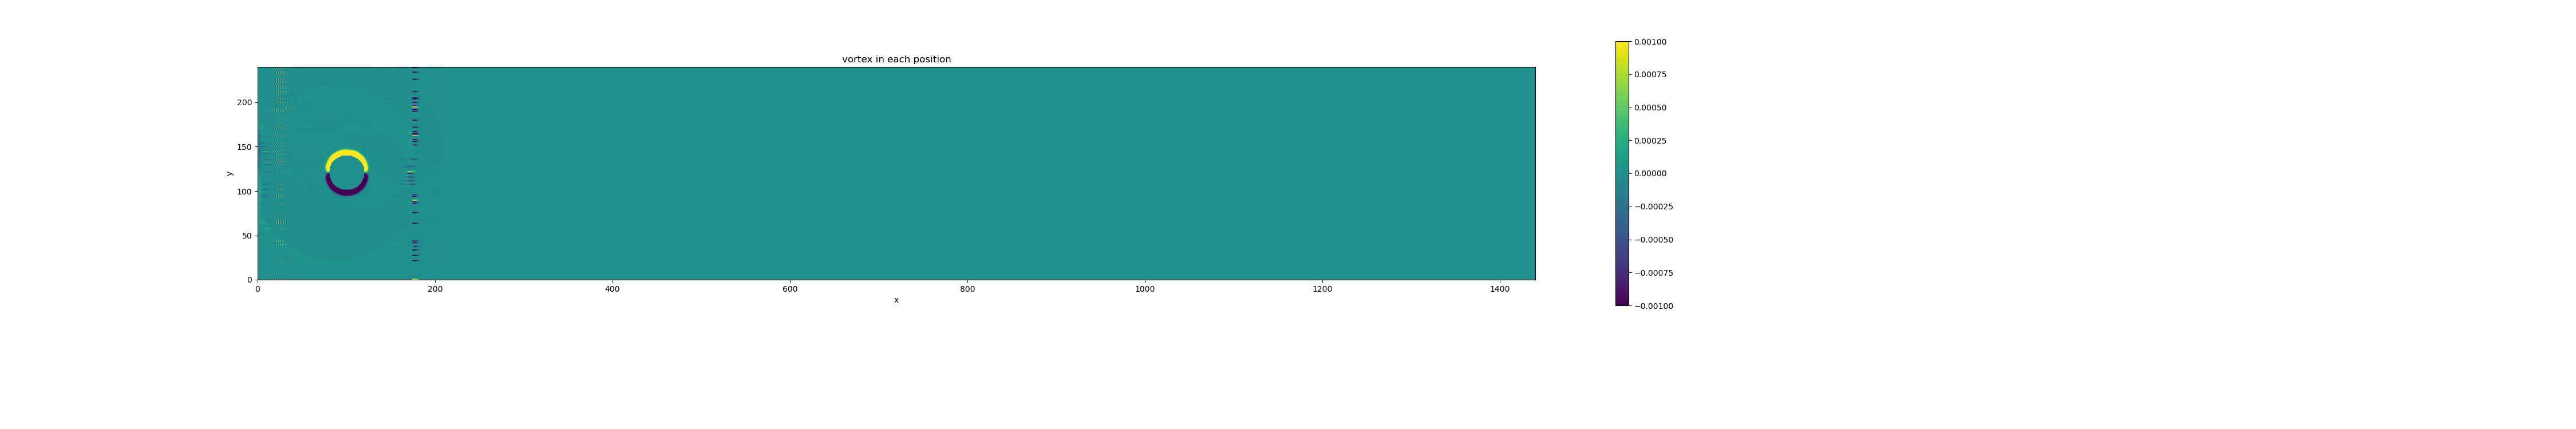

KeyboardInterrupt: 

In [15]:
interval=50
pointx=int(NX*100/360)
pointy=int(NY/2)
vortex_arr=[]
fg,ax = plt.subplots(1,1,figsize=(6*(NX/NY),6))

nthread=32
for t in range(0,NSTEPS):

    PropagateFluid[(NX//nthread,NY//2),(nthread,2)](f0g,f1g,f2g,ug,vg,nodes_near_neighbor_arr_g,vortex_g,f0eqg,feqg)
    FluidEvolve[(NX//nthread,NY//2),(nthread,2)](f0g,f1g,f2g,f0eqg,feqg)
    
#     vortex_time=vortex_g.copy_to_host().reshape(NY,NX)
#     vortex_arr.append(vortex_time[pointy][pointx])
    

    #plot vortex each 10 time steps
    if t%interval==0:
        ax.clear()
      #fetch date from GPU
        vortex_time=vortex_g.copy_to_host().reshape(NY,NX)
        vortex_arr.append(vortex_time[pointy][pointx])
        UX = ug.copy_to_host().reshape(NY,NX)
        UY=vg.copy_to_host().reshape(NY,NX)
        Vortex=vortex_g.copy_to_host().reshape(NY,NX)  
        indexarr=np.ones((NX,NY))
        for i in range(0,NX):
            for j in range(0,NY):
                if wallnodesarr[i][j]==1:
                    indexarr[i][j]=0
        Vortex_nonwallnodes=np.multiply(Vortex,indexarr.transpose())   

        # Plot vortex vs x position
        vortexmax=np.max(Vortex_nonwallnodes)
        vortexmin=np.min(Vortex_nonwallnodes)
        # umax=0.1
        # umin=0
        
        indexarr=np.ones((NX,NY))
        for i in range(0,NX):
            for j in range(0,NY):
                if wallnodesarr[i][j]==1:
                    indexarr[i][j]=0
        uc=np.multiply(UX,indexarr.transpose()) 
        vc=np.multiply(UY,indexarr.transpose()) 
        velocity=np.sqrt(np.square(uc)+np.square(vc))

        #plot vortex

        imshowplt=ax.imshow(Vortex_nonwallnodes, cmap ="viridis", extent=[0, NX, 0, NY],vmin=-.001,vmax=.001,origin='lower')
        ax.set_title('vortex in each position')

        
# #         plot velocity
#         imshowplt=ax.imshow(velocity, cmap ="viridis", vmin=0,vmax=0.18,extent=[0, NX, 0, NY])
# #         imshowplt=ax.imshow(velocity, cmap ="viridis", extent=[0, NX, 0, NY])
#         ax.set_title('velocity in each position')


        if t >0:
                cb.remove()
        cb=plt.colorbar(imshowplt)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
    
        fg.canvas.draw()


    
            



# Data Analysis

In [16]:
#Fetch data from GPU
UX = ug.copy_to_host().reshape(NY,NX)
UY=vg.copy_to_host().reshape(NY,NX)
Vortex=vortex_g.copy_to_host().reshape(NY,NX)

In [17]:
xi = np.linspace(0,NX-1,NX)
yi = np.linspace(0,NY-1,NY)

In [18]:
Vortex.shape

(240, 1440)

In [19]:
conversion=(10/0.5)/(cylinder_D/u_in)

<IPython.core.display.Javascript object>


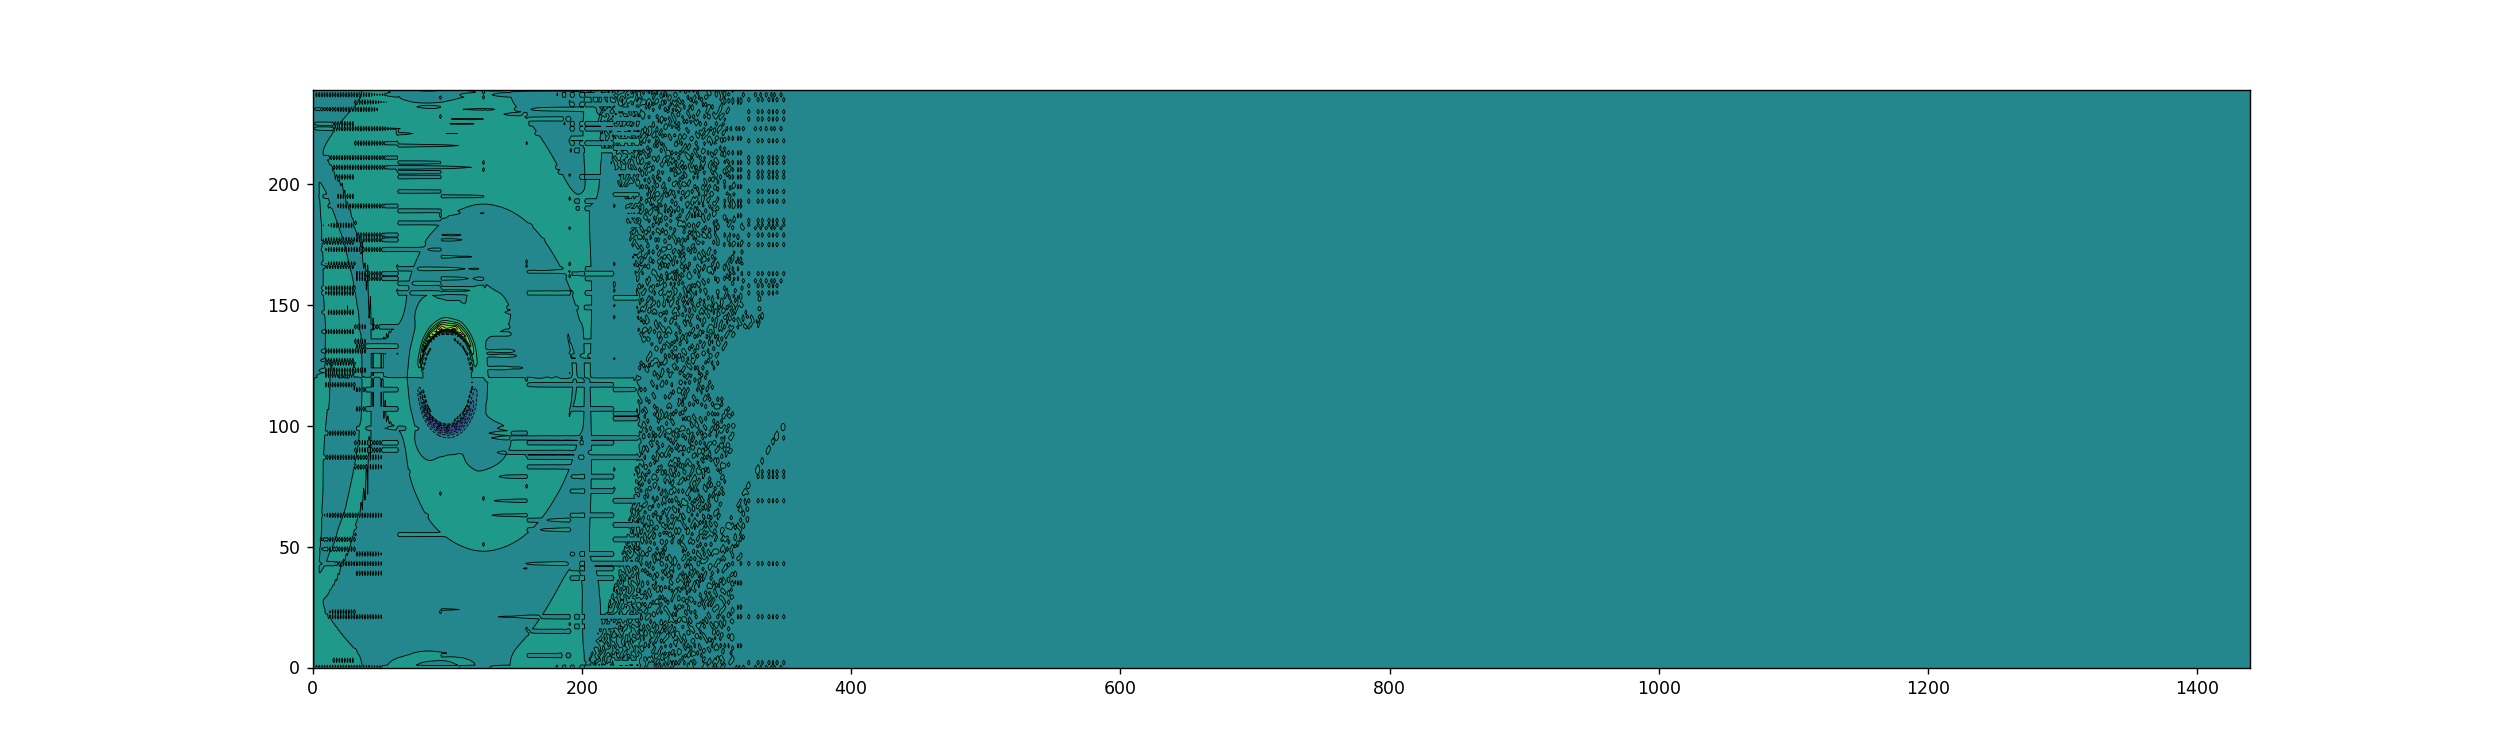

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.contour(xi, yi, Vortex, levels=14, linewidths=0.5, colors='k')
cntr1 = ax.contourf(xi, yi, Vortex, levels=14, cmap="viridis")

fig.savefig('Contuor_plot.png')

<IPython.core.display.Javascript object>


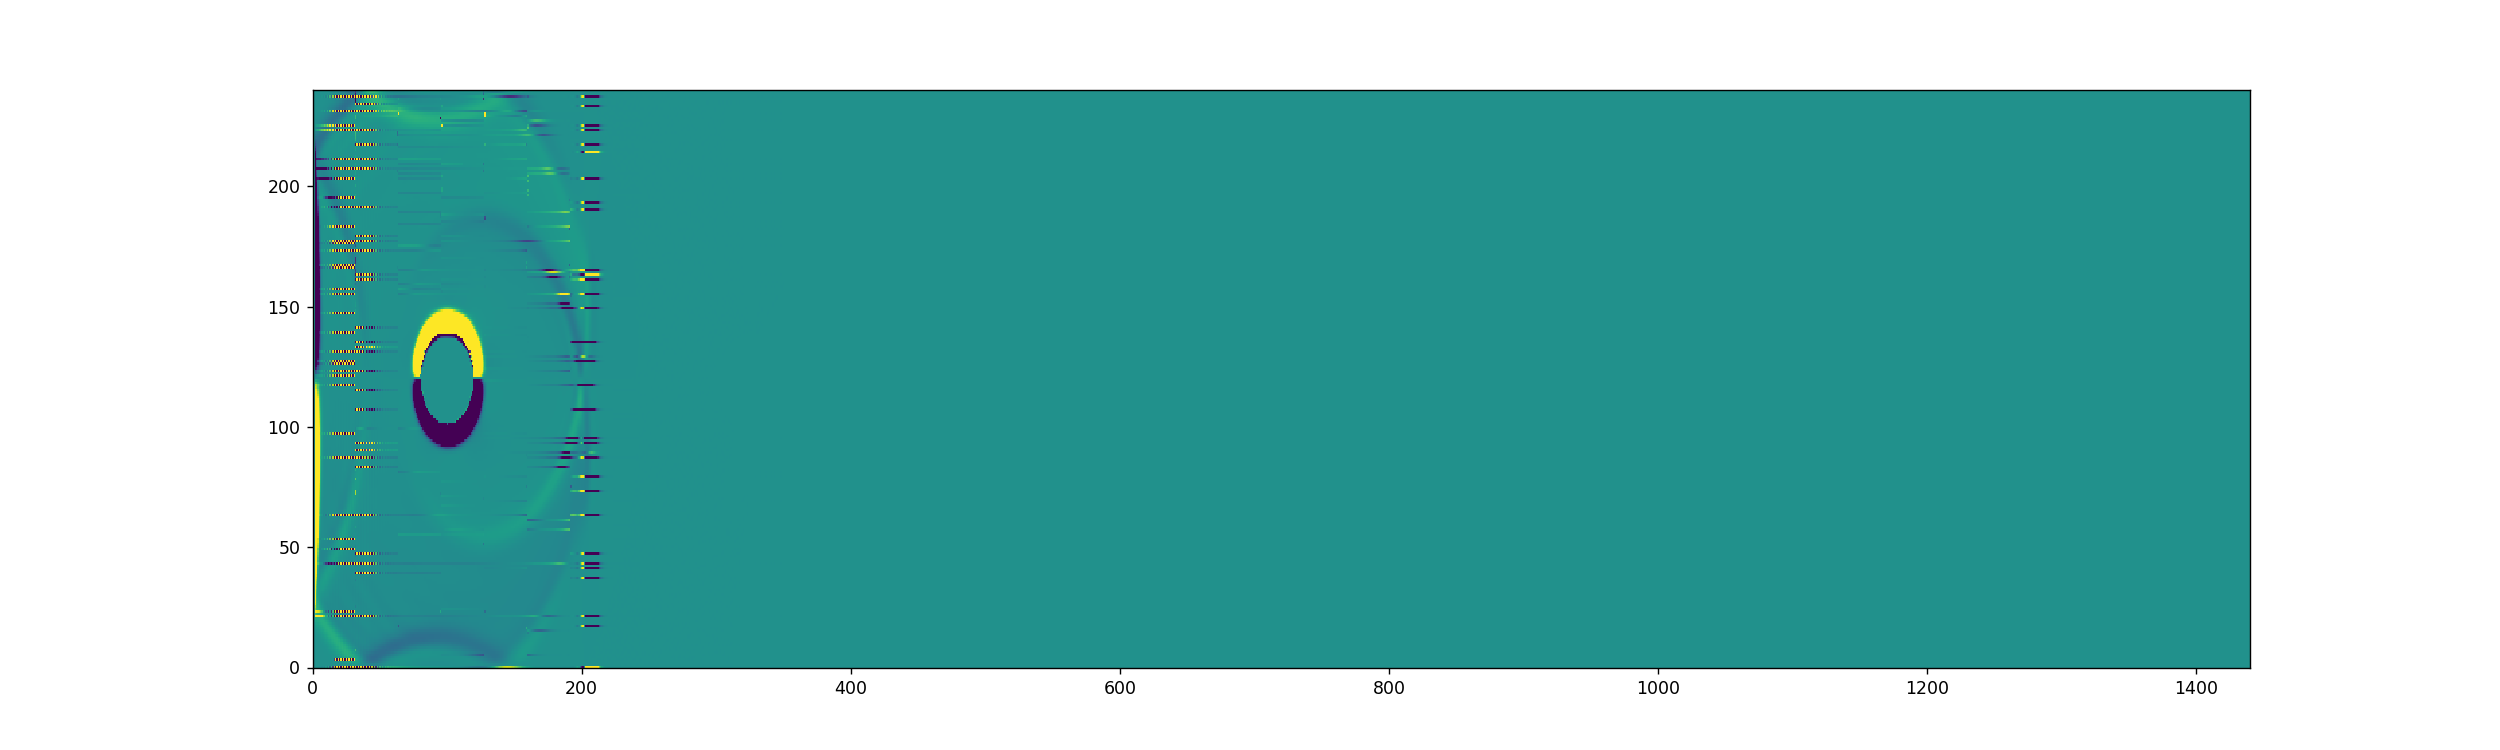

In [21]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.pcolor(Vortex,cmap="viridis",vmin=-0.01*conversion,vmax=0.01*conversion)
fig.savefig('Heat_map.png')


In [30]:
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

In [31]:
ts=interval*1
sr = 1/ts #sampling frequency
X = DFT(vortex_arr)
N = len(X) # number of points
n = np.arange(N) # list of integers for each point
U=u_in
D=cylinder_D



In [32]:
# calculate the frequency
T = N/sr
freq = n/T

#Display only one side of the plot (fourier transform is symmetric)
n_oneside = N//2
f_oneside = freq[:n_oneside]

#Normaize the amplitude
X_oneside = X[:n_oneside]/n_oneside

In [33]:
X

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [34]:
f_oneside

array([0.    , 0.0025, 0.005 , 0.0075])

Shedding frequency: 0.0
Strouhal #: 0.0


<IPython.core.display.Javascript object>


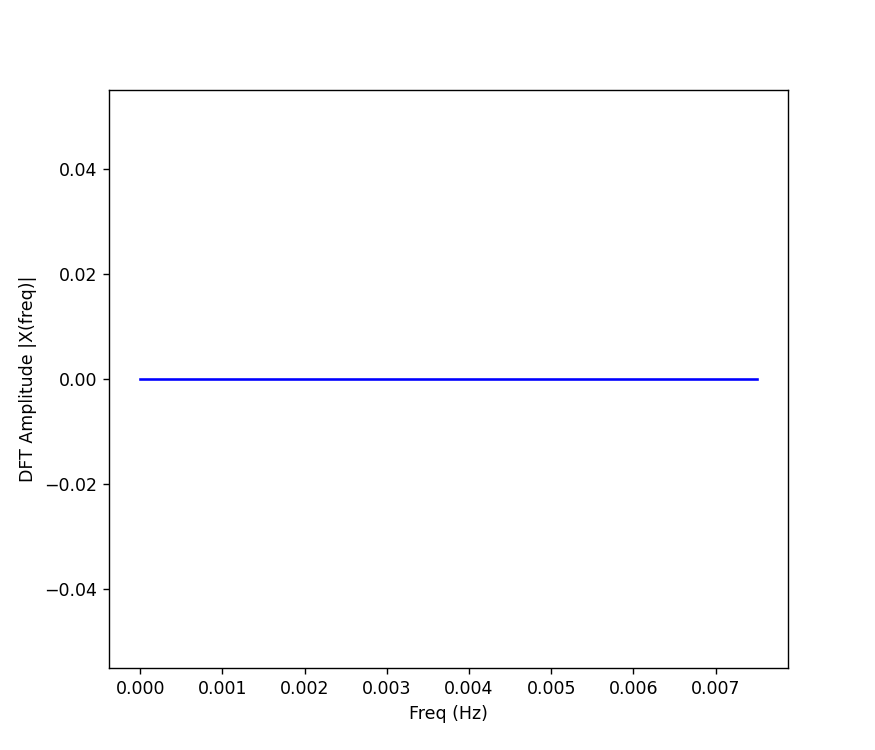

Text(0, 0.5, 'DFT Amplitude |X(freq)|')

In [35]:
#Normaize the amplitude
X_oneside = X[:n_oneside]/n_oneside

#Calculate the highest amplitude frequency
max_f = f_oneside[X_oneside.argmax()]
Sr = max_f/(U/D)
print("Shedding frequency: " + str(max_f))
print("Strouhal #: " + str(Sr))

#Plot the results
fig, ax = plt.subplots(1,1,figsize=(7,6))

ax.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('DFT Amplitude |X(freq)|')

In [36]:
interval

50

In [37]:
timearr=np.arange(NSTEPS/interval)
# fg,ax = plt.subplots(1,1,figsize=(6*(NX/NY),6))
fg,ax = plt.subplots(1,1,figsize=(8,8))
# ax.plot(analy_yarr,analy_value)
ax.scatter(timearr,vortex_arr)
ax.set_xlabel('timesteps')
ax.set_ylabel('vortex')
ax.set_title('vortex at x=100,y=center')



<IPython.core.display.Javascript object>

ValueError: x and y must be the same size